<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/linreg_hierarchical_pymc3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Hierarchical Bayesian Linear Regression in NumPyro

The text and code for this notebook are taken directly from [this blog post](https://twiecki.io/blog/2014/03/17/bayesian-glms-3/) by Thomas Wiecki and Danne Elbers and rewritten in NumPyro.

[Original notebook](https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/GLM_hierarchical.ipynb). 


 

Gelman et al.'s (2007) radon dataset is a classic for hierarchical modeling. In this dataset the amount of the radioactive gas radon has been measured among different households in all county's of several states. Radon gas is known to be the highest cause of lung cancer in non-smokers. It is believed to enter the house through the basement. Moreover, its concentration is thought to differ regionally due to different types of soil.

Here we'll investigate this difference and try to make predictions of radon levels in different countys and where in the house radon was measured. In this example we'll look at Minnesota, a state that contains 85 county's in which different measurements are taken, ranging from 2 till 80 measurements per county. 


First, we will import the libraries we need:

In [1]:
%matplotlib inline
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro arviz
!pip install arviz
!pip install seaborn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import arviz as az
import seaborn as sns
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from jax import random

Then, we'll load the data: 

In [2]:
url = "https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/radon.csv?raw=true"
data = pd.read_csv(url)

In [3]:
county_names = data.county.unique()
county_idx = data["county_code"].values

The relevant part of the data we will model looks as follows:

In [4]:
data[["county", "log_radon", "floor"]].head()

,county,log_radon,floor
0,AITKIN,0.832909,1.0
1,AITKIN,0.832909,0.0
2,AITKIN,1.098612,0.0
3,AITKIN,0.095310,0.0
4,ANOKA,1.163151,0.0


As you can see, we have multiple `radon` measurements (log-converted to be on the real line) in a `county` and whether the measurement has been taken in the basement (`floor` == 0) or on the first floor (`floor` == 1). Here we want to test the prediction that radon concentrations are higher in the basement.

## The Models

### Pooling of measurements
Now you might say: "That's easy! I'll just pool all my data and estimate one big regression to asses the influence of measurement across all counties". In math-speak that model would be:

$$radon_{i, c} = \alpha + \beta*\text{floor}_{i, c} + \epsilon$$ 

Where $i$ represents the measurement, $c$ the county and floor contains which floor the measurement was made.  Critically, we are only estimating *one* intercept and *one* slope for all measurements over all counties.

### Separate regressions
But what if we are interested whether different counties actually have different relationships (slope) and different base-rates of radon (intercept)? Then you might say "OK then, I'll just estimate $n$ (number of counties) different regresseions -- one for each county". In math-speak that model would be:

$$radon_{i, c} = \alpha_{c} + \beta_{c}*\text{floor}_{i, c} + \epsilon_c$$

Note that we added the subindex $c$ so we are estimating $n$ different $\alpha$s and $\beta$s -- one for each county.

This is the extreme opposite model, where above we assumed all counties are exactly the same, here we are saying that they share no similarities whatsoever which ultimately is also unsatisifying.

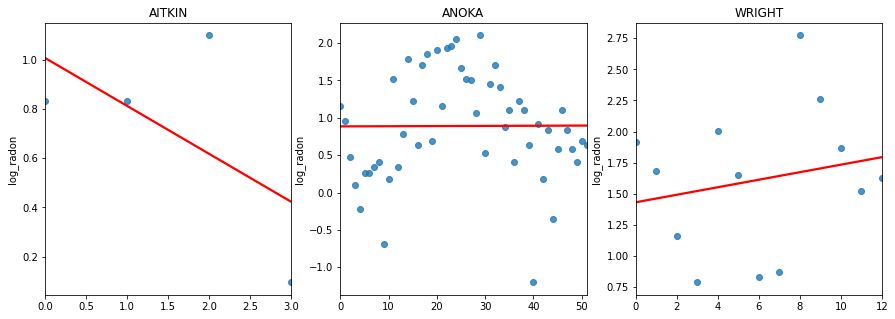

In [5]:
def chart(county_name, ax):
    c_data = data[data.county == county_name]
    c_data = c_data.reset_index(drop=True)
    x = c_data.index
    y = c_data.log_radon
    ax.set_title(county_name)
    ax = sns.regplot(x=x, y=y, ax=ax, ci=None, line_kws={"color": "red"})


f, axes = plt.subplots(1, 3, figsize=(15, 5))
chart("AITKIN", axes[0])
chart("ANOKA", axes[1])
chart("WRIGHT", axes[2])


### Hierarchical Regression: The best of both worlds

Fortunately there is a middle ground to both of these extreme views. Specifically, we may assume that while $\alpha$s and $\beta$s are different for each county, the coefficients all come from a common group distribution:

$$\alpha_{c} \sim \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$\beta_{c} \sim \mathcal{N}(\mu_{\beta}, \sigma_{\beta}^2)$$

We thus assume the intercepts $\alpha$ and slopes $\beta$ to come from a normal distribution centered around their respective group mean $\mu$ with a certain standard deviation $\sigma^2$, the values (or rather posteriors) of which we also estimate. That's why this is called multilevel or hierarchical modeling.

Note that the above is not a complete Bayesian model specification as we haven't defined priors or hyperpriors (i.e. priors for the group distribution, $\mu$ and $\sigma$). These will be used in the model implementation below but only distract here.

## Probabilistic Programming

### Individual/non-hierarchical model

To really highlight the effect of the hierarchical linear regression we'll first estimate the non-hierarchical Bayesian model from above (separate regressions). For each county a new estimate of the parameters is initiated. As we have no prior information on what the intercept or regressions could be we are placing a Normal distribution centered around 0 with a wide standard-deviation. We'll assume the measurements are normally distributed with noise $\epsilon$ on which we place a Half-Cauchy distribution.  

In [6]:
def model(floor, log_radon):
    # Intercept prior
    a = numpyro.sample("alpha", dist.Normal(0.0, 1))
    # Slope prior
    b = numpyro.sample("beta", dist.Normal(0.0, 1))
    # Model error prior
    eps = numpyro.sample("eps", dist.HalfCauchy(1.0))
    # Linear model
    mu = a + b * floor
    # Data likelihood
    numpyro.sample("obs", dist.Normal(mu, eps), obs=log_radon)

**It takes 5 minutes.** You can remove change progress_bar as **True** unless you want to suppress the output.

In [7]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
indiv_traces, num_divergences = {}, {}

for county_name in county_names:
    # Select subset of data belonging to county
    c_data = data.loc[data.county == county_name]
    c_data = c_data.reset_index(drop=True)

    c_log_radon = c_data.log_radon.values
    c_floor_measure = c_data.floor.values

    rng_key, rng_key_ = random.split(rng_key)

    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, progress_bar=False)
    mcmc.run(rng_key_, c_floor_measure, c_log_radon)

    num_divergences[county_name] = np.sum(mcmc.get_extra_fields()["diverging"])
    indiv_traces[county_name] = mcmc.get_samples()

In order to check that mcmc worked, let's look at the number of divergences:

In [8]:
num_divergences

{'AITKIN': DeviceArray(0, dtype=int32),
 'ANOKA': DeviceArray(0, dtype=int32),
 'BECKER': DeviceArray(0, dtype=int32),
 'BELTRAMI': DeviceArray(0, dtype=int32),
 'BENTON': DeviceArray(0, dtype=int32),
 'BIG STONE': DeviceArray(0, dtype=int32),
 'BLUE EARTH': DeviceArray(0, dtype=int32),
 'BROWN': DeviceArray(0, dtype=int32),
 'CARLTON': DeviceArray(0, dtype=int32),
 'CARVER': DeviceArray(0, dtype=int32),
 'CASS': DeviceArray(0, dtype=int32),
 'CHIPPEWA': DeviceArray(0, dtype=int32),
 'CHISAGO': DeviceArray(0, dtype=int32),
 'CLAY': DeviceArray(0, dtype=int32),
 'CLEARWATER': DeviceArray(0, dtype=int32),
 'COOK': DeviceArray(0, dtype=int32),
 'COTTONWOOD': DeviceArray(0, dtype=int32),
 'CROW WING': DeviceArray(0, dtype=int32),
 'DAKOTA': DeviceArray(0, dtype=int32),
 'DODGE': DeviceArray(0, dtype=int32),
 'DOUGLAS': DeviceArray(0, dtype=int32),
 'FARIBAULT': DeviceArray(0, dtype=int32),
 'FILLMORE': DeviceArray(16, dtype=int32),
 'FREEBORN': DeviceArray(0, dtype=int32),
 'GOODHUE': Devi

## Hierarchical Model
Instead of initiating the parameters separatly, the hierarchical model initiates group parameters that consider the county's not as completely different but as having an underlying similarity. These distributions are subsequently used to influence the distribution of each county's $\alpha$ and $\beta$.

In [9]:
def hierarchical_model_centered(county, floor, log_of_radon):
    # Hyperpriors
    mu_a = numpyro.sample("mu_alpha", dist.Normal(0.0, 1.0))
    sigma_a = numpyro.sample("sigma_alpha", dist.HalfCauchy(1.0))
    mu_b = numpyro.sample("mu_beta", dist.Normal(0.0, 1.0))
    sigma_b = numpyro.sample("sigma_beta", dist.HalfCauchy(1.0))

    unique_counties = np.unique(county)
    n_counties = len(unique_counties)

    with numpyro.plate("counties", n_counties):
        # Intercept for each county, distributed around group mean mu_a
        alpha = numpyro.sample("alpha", dist.Normal(mu_a, sigma_a))
        # Intercept for each county, distributed around group mean mu_a
        beta = numpyro.sample("beta", dist.Normal(mu_b, sigma_b))

    # Model error
    eps = numpyro.sample("eps", dist.HalfCauchy(scale=1.0))
    # Expected value
    radon_est = alpha[county_idx] + beta[county_idx] * floor

    with numpyro.plate("data", len(county)):
        # Data likelihood
        obs = numpyro.sample("obs", dist.Normal(radon_est, eps), obs=log_of_radon)
    return obs

In [10]:
nuts_kernel = NUTS(hierarchical_model_centered)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000)
mcmc.run(rng_key, data.county.values, data.floor.values, data.log_radon.values)

hierarchical_trace = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:11<00:00, 271.63it/s, 31 steps of size 1.08e-01. acc. prob=0.94]


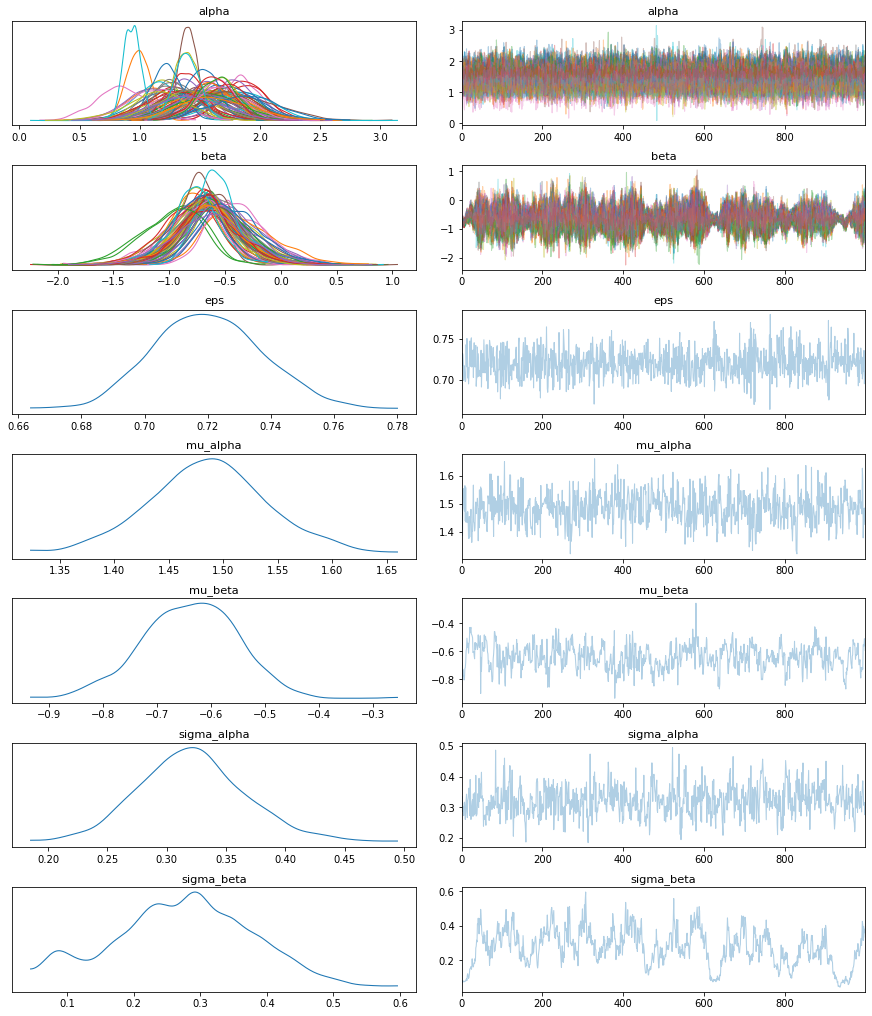

In [11]:
inference_data = az.from_numpyro(mcmc)
az.plot_trace(inference_data, compact=True);

The marginal posteriors in the left column are highly informative. `mu_alpha` tells us the group mean (log) radon levels. `mu_beta` tells us that the slope is significantly negative (no mass above zero), meaning that radon concentrations are higher in the basement than first floor. We can also see by looking at the marginals for `a` that there is quite some differences in radon levels between counties; the different widths are related to how much measurements we have per county, the more, the higher our confidence in that parameter estimate.

## Posterior Predictive Check

### The Root Mean Square Deviation

To find out which of the models works better we can calculate the Root Mean Square Deviaton (RMSD). This posterior predictive check revolves around recreating the data based on the parameters found at different moments in the chain. The recreated or predicted values are subsequently compared to the real data points, the model that predicts data points closer to the original data is considered the better one. Thus, the lower the RMSD the better.

When computing the RMSD (code not shown) we get the following result:

  * individual/non-hierarchical model: 0.13
  * hierarchical model: 0.08

As can be seen above the hierarchical model performs a lot better than the non-hierarchical model in predicting the radon values. Following this, we'll plot some examples of county's showing the true radon values, the hierarchial predictions and the non-hierarchical predictions. 

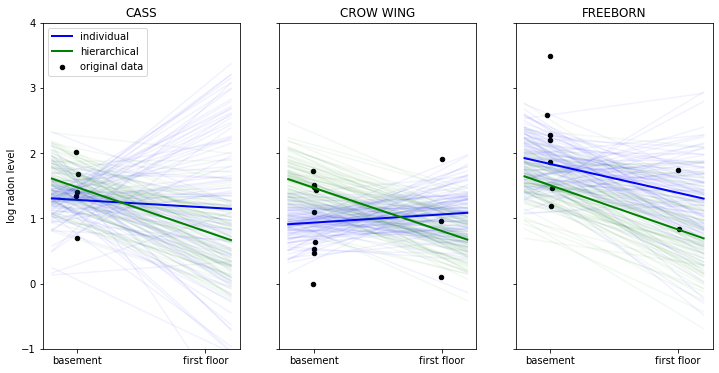

In [12]:
selection = ["CASS", "CROW WING", "FREEBORN"]
fig, axis = plt.subplots(1, 3, figsize=(12, 6), sharey=True, sharex=True)
axis = axis.ravel()
for i, c in enumerate(selection):
    c_data = data.loc[data.county == c]
    c_data = c_data.reset_index(drop=True)
    z = list(c_data["county_code"])[0]

    xvals = np.linspace(-0.2, 1.2)
    for a_val, b_val in zip(indiv_traces[c]["alpha"][::10], indiv_traces[c]["beta"][::10]):
        axis[i].plot(xvals, a_val + b_val * xvals, "b", alpha=0.05)
    axis[i].plot(
        xvals,
        indiv_traces[c]["alpha"][::10].mean() + indiv_traces[c]["beta"][::10].mean() * xvals,
        "b",
        alpha=1,
        lw=2.0,
        label="individual",
    )
    for a_val, b_val in zip(hierarchical_trace["alpha"][::10][z], hierarchical_trace["beta"][::10][z]):
        axis[i].plot(xvals, a_val + b_val * xvals, "g", alpha=0.05)
    axis[i].plot(
        xvals,
        hierarchical_trace["alpha"][::10][z].mean() + hierarchical_trace["beta"][::10][z].mean() * xvals,
        "g",
        alpha=1,
        lw=2.0,
        label="hierarchical",
    )
    axis[i].scatter(
        c_data.floor + np.random.randn(len(c_data)) * 0.01,
        c_data.log_radon,
        alpha=1,
        color="k",
        marker=".",
        s=80,
        label="original data",
    )
    axis[i].set_xticks([0, 1])
    axis[i].set_xticklabels(["basement", "first floor"])
    axis[i].set_ylim(-1, 4)
    axis[i].set_title(c)
    if not i % 3:
        axis[i].legend()
        axis[i].set_ylabel("log radon level")

In the above plot we have the data points in black of three selected counties. The thick lines represent the mean estimate of the regression line of the individual (blue) and hierarchical model (in green). The thinner lines are regression lines of individual samples from the posterior and give us a sense of how variable the estimates are.

When looking at the county 'CASS' we see that the non-hierarchical estimation has huge uncertainty about the radon levels of first floor measurements -- that's because we don't have any measurements in this county. The hierarchical model, however, is able to apply what it learned about the relationship between floor and radon-levels from other counties to CASS and make sensible predictions even in the absence of measurements.

We can also see how the hierarchical model produces more robust estimates in 'CROW WING' and 'FREEBORN'. In this regime of few data points the non-hierarchical model reacts more strongly to individual data points because that's all it has to go on. 

Having the group-distribution constrain the coefficients we get meaningful estimates in all cases as we apply what we learn from the group to the individuals and vice-versa.

# Shrinkage
Shrinkage describes the process by which our estimates are "pulled" towards the group-mean as a result of the common group distribution -- county-coefficients very far away from the group mean have very low probability under the normality assumption. In the non-hierachical model every county is allowed to differ completely from the others by just using each county's data, resulting in a model more prone to outliers (as shown above). 

In [13]:
hier_a = hierarchical_trace["alpha"].mean(axis=0)
hier_b = hierarchical_trace["beta"].mean(axis=0)
indv_a = [indiv_traces[c]["alpha"].mean() for c in county_names]
indv_b = [indiv_traces[c]["beta"].mean() for c in county_names]

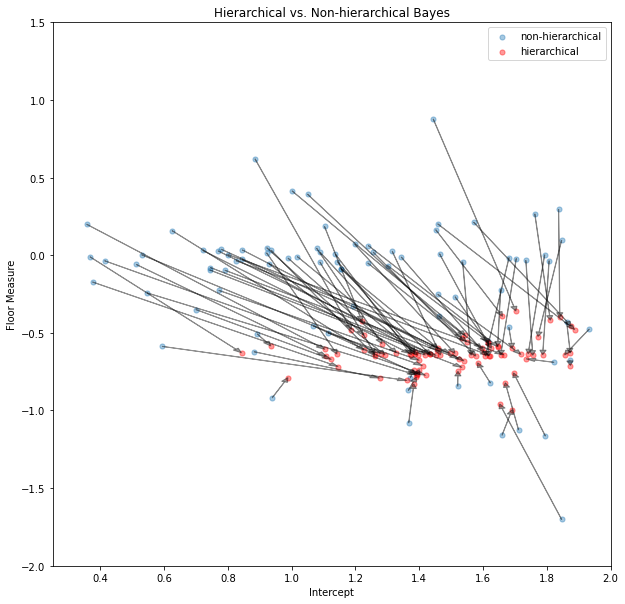

In [14]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(
    111,
    xlabel="Intercept",
    ylabel="Floor Measure",
    title="Hierarchical vs. Non-hierarchical Bayes",
    xlim=(0.25, 2),
    ylim=(-2, 1.5),
)

ax.scatter(indv_a, indv_b, s=26, alpha=0.4, label="non-hierarchical")
ax.scatter(hier_a, hier_b, c="red", s=26, alpha=0.4, label="hierarchical")
for i in range(len(indv_b)):
    ax.arrow(
        indv_a[i],
        indv_b[i],
        hier_a[i] - indv_a[i],
        hier_b[i] - indv_b[i],
        fc="k",
        ec="k",
        length_includes_head=True,
        alpha=0.4,
        head_width=0.02,
    )
ax.legend();

In the shrinkage plot above we show the coefficients of each county's non-hierarchical posterior mean (blue) and the hierarchical posterior mean (red). To show the effect of shrinkage on a single coefficient-pair (alpha and beta) we connect the blue and red points belonging to the same county by an arrow. Some non-hierarchical posteriors are so far out that we couldn't display them in this plot (it makes the axes to wide). Interestingly, all hierarchical posteriors of the floor-measure seem to be around -0.6 confirming out prediction that radon levels are higher in the basement than in the first floor. The differences in intercepts (which we take for type of soil) differs among countys indicating that meaningful regional differences exist in radon concentration. This information would have been difficult to find when just the non-hierarchial model had been used and estimates for individual counties would have been much more noisy.

# Summary

In this post, co-authored by Danne Elbers, we showed how a multi-level hierarchical Bayesian model gives the best of both worlds when we have multiple sets of measurements we expect to have similarity. The naive approach either pools all data together and ignores the individual differences, or treats each set as completely separate leading to noisy estimates as shown above. By placing a group distribution on the individual sets we can learn about each set and the group simultaneously. Probabilistic Programming in NumPyro then makes Bayesian estimation of this model trivial.


## References
  * [The Inference Button: Bayesian GLMs made easy with PyMC3](https://twiecki.github.io/blog/2013/08/12/bayesian-glms-1/)
  * [This world is far from Normal(ly distributed): Bayesian Robust Regression in PyMC3](https://twiecki.github.io/blog/2013/08/27/bayesian-glms-2/)  
  * [Chris Fonnesbeck repo containing a more extensive analysis](https://github.com/fonnesbeck/multilevel_modeling/)
  * [Shrinkage in multi-level hierarchical models](http://doingbayesiandataanalysis.blogspot.com/2012/11/shrinkage-in-multi-level-hierarchical.html) by John Kruschke
  * Gelman, A.; Carlin; Stern; and Rubin, D., 2007, "Replication data for: Bayesian Data Analysis, Second Edition", 
  * Gelman, A., & Hill, J. (2006). Data Analysis Using Regression and Multilevel/Hierarchical Models (1st ed.). Cambridge University Press.
  * Gelman, A. (2006). Multilevel (Hierarchical) modeling: what it can and cannot do. Technometrics, 48(3), 432–435.